In [1]:
import os
from pathlib import Path
os.chdir(Path('~/git_folder/eye_tracking/').expanduser())

import pandas as pd
import numpy as np

from models.ensemble_inference import load_xgboost_model, load_jcafnet_model, predict_xgboost, soft_voting_ensemble
from utils.train import evaluate_pytorch_model

import matplotlib.pyplot as plt
import seaborn as sns

****
# Load models and datasets
****

In [2]:
xgb_model_path = "trainings/logs/xgboost_classifier/best_model.pkl"
jcafnet_ckpt = "trainings/logs/jcafnet_classifier/hardy-water-3/epoch40-val_acc0.72.ckpt"
jcafnet_meta = "trainings/logs/jcafnet_classifier/hardy-water-3/model_metadata.json"
# data_path = str(Path('~/store/eye_tracking/splits').expanduser())
data_path = str(Path('/store/kruu/eye_tracking/splits').expanduser())

In [3]:
# Same samples as XGBoost but different processing
jcafnet_split_files = [f"{data_path}/{s}.parquet" for s in ["train", "val", "test"]]
xgboost_split_files = [f"{data_path}/{s}.parquet" for s in ["train_xgboost", "val_xgboost", "test_xgboost"]]

if all(Path(f).exists() for f in jcafnet_split_files):
    print("Loading jcafnet dataset splits...")
    jcafnet_train_df = pd.read_parquet(jcafnet_split_files[0])
    jcafnet_val_df = pd.read_parquet(jcafnet_split_files[1])
    jcafnet_test_df = pd.read_parquet(jcafnet_split_files[2])

if all(Path(f).exists() for f in xgboost_split_files):
    print("Loading xgboost dataset splits...")
    xgboost_train_df = pd.read_parquet(xgboost_split_files[0])
    xgboost_val_df = pd.read_parquet(xgboost_split_files[1])
    xgboost_test_df = pd.read_parquet(xgboost_split_files[2])

Loading jcafnet dataset splits...
Loading xgboost dataset splits...


In [4]:
xg_boost = load_xgboost_model(xgb_model_path)
jcafnet, meta_jcafnet = load_jcafnet_model(jcafnet_ckpt, jcafnet_meta)

/home/kruu/git_folder/eye_tracking/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kruu/git_folder/eye_tracking/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


****
# Inference
****

## JCAFNet

In [5]:
features = {
    "gaze": ["Gaze point X", "Gaze point Y", "Gaze Velocity", "Gaze Acceleration"],
    "mouse": ["Mouse position X", "Mouse position Y", "Mouse Velocity", "Mouse Acceleration"],
    "joint": ["Gaze-Mouse Distance", "Angle Between Gaze and Mouse"]
}

preds_jcafnet = evaluate_pytorch_model(jcafnet,
                                           jcafnet_test_df,
                                           meta_jcafnet["features"],
                                           meta_jcafnet["num_classes"],
                                           meta_jcafnet["mean"], 
                                           meta_jcafnet["std"])

🧠 PyTorch Evaluation: Loss = 1.3059, Accuracy = 0.7083


## XGBoost

In [6]:
preds_xgboost = predict_xgboost(
    test_df=xgboost_test_df,
    model_path="trainings/logs/xgboost_classifier/best_model.pkl",
    selected_features_path="trainings/logs/xgboost_classifier/selected_features.pkl",
)

XGBoost Accuracy: 0.7639


## Soft voting

In [7]:
probs_cols = ["class_0_prob", "class_1_prob", "class_2_prob", "class_3_prob", "class_4_prob","class_5_prob"]

ensemble_df = soft_voting_ensemble(
    probs_model1=preds_jcafnet[probs_cols].to_numpy(),
    probs_model2=preds_xgboost[probs_cols].to_numpy(),
    true_labels=preds_jcafnet["true_label"].to_numpy(),
    weight_model1=0.5,
    weight_model2=0.5,
    ids=preds_jcafnet["id"].to_numpy()
)

Soft Voting Ensemble Accuracy: 0.8194


****
# Plots
****

## Accuracies

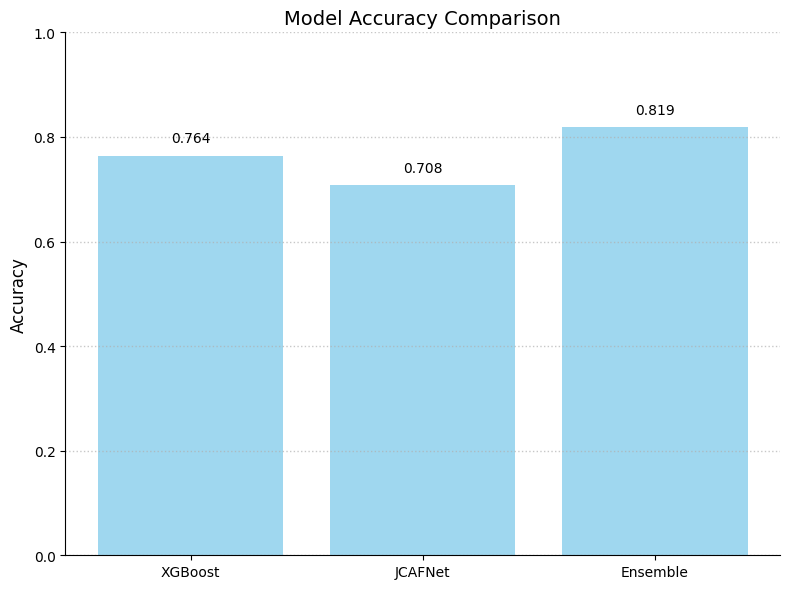

In [9]:
accuracies = {
    "XGBoost": 0.764,
    "JCAFNet": 0.708,
    "Ensemble": 0.819,
}

# Extract data
models = list(accuracies.keys())
scores = list(accuracies.values())

# Plot setup
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(models, scores, color='skyblue', alpha=0.8)

# Add horizontal grid
ax.yaxis.grid(True, linestyle=':', linewidth=1, alpha=0.7)

# Annotate bars with accuracy values
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{score:.3f}", 
            ha='center', va='bottom', fontsize=10)

# Aesthetic adjustments
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Model Accuracy Comparison", fontsize=14)
ax.set_ylim(0, 1)

# Clean up spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()


## Per-class accuracy

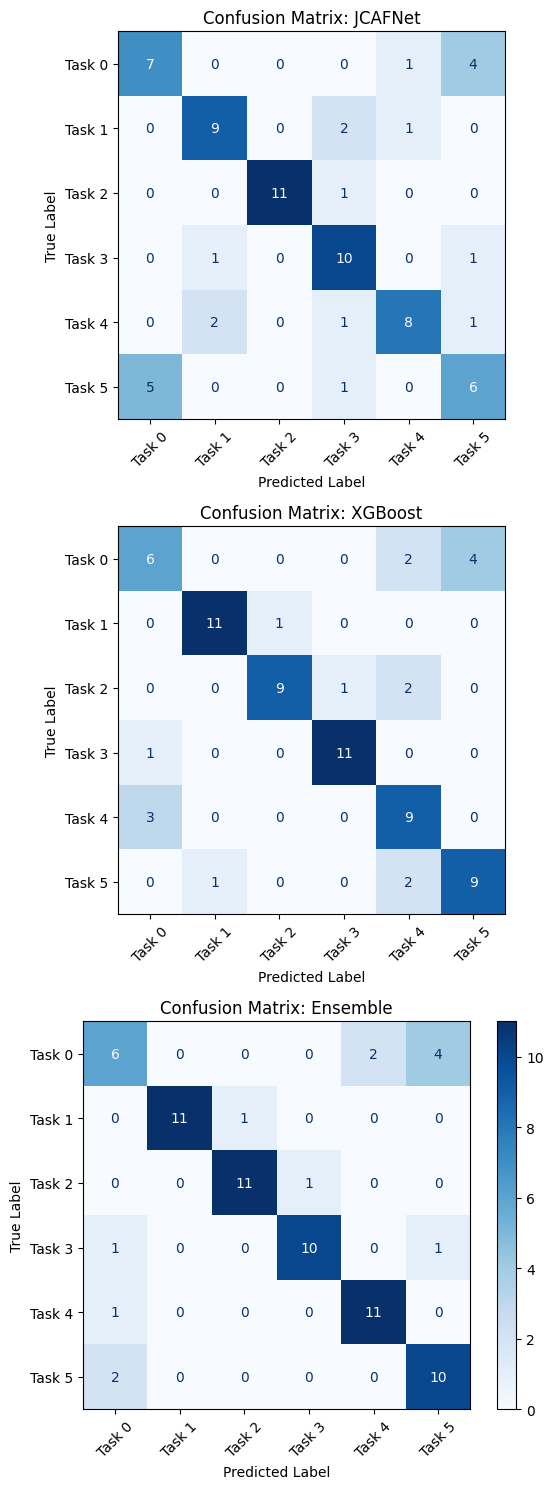

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrices
cm_jcafnet = confusion_matrix(preds_jcafnet["true_label"], preds_jcafnet["pred_label"])
cm_xgboost = confusion_matrix(preds_xgboost["true_label"], preds_xgboost["pred_label"])
cm_ensemble = confusion_matrix(ensemble_df["true_label"], ensemble_df["pred_label"])

# Optional class labels for axes
class_names = ["Task 0", "Task 1", "Task 2", "Task 3", "Task 4", "Task 5"]

# Set up 3-row, 1-column layout
fig, axes = plt.subplots(3, 1, figsize=(6, 15))

# Plot confusion matrices
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_jcafnet, display_labels=class_names)
disp1.plot(ax=axes[0], colorbar=False, cmap="Blues", xticks_rotation=45)
axes[0].set_title("Confusion Matrix: JCAFNet")

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_xgboost, display_labels=class_names)
disp2.plot(ax=axes[1], colorbar=False, cmap="Blues", xticks_rotation=45)
axes[1].set_title("Confusion Matrix: XGBoost")

disp3 = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=class_names)
disp3.plot(ax=axes[2], colorbar=True, cmap="Blues", xticks_rotation=45)
axes[2].set_title("Confusion Matrix: Ensemble")

# Adjust spacing
for ax in axes:
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()


/tmp/ipykernel_37412/2845362380.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("true_label").apply(lambda g: (g["true_label"] == g["pred_label"]).mean())
/tmp/ipykernel_37412/2845362380.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("true_label").apply(lambda g: (g["true_label"] == g["pred_label"]).mean())
/tmp/ipykernel_37412/2845362380.py:7: DeprecationWarning

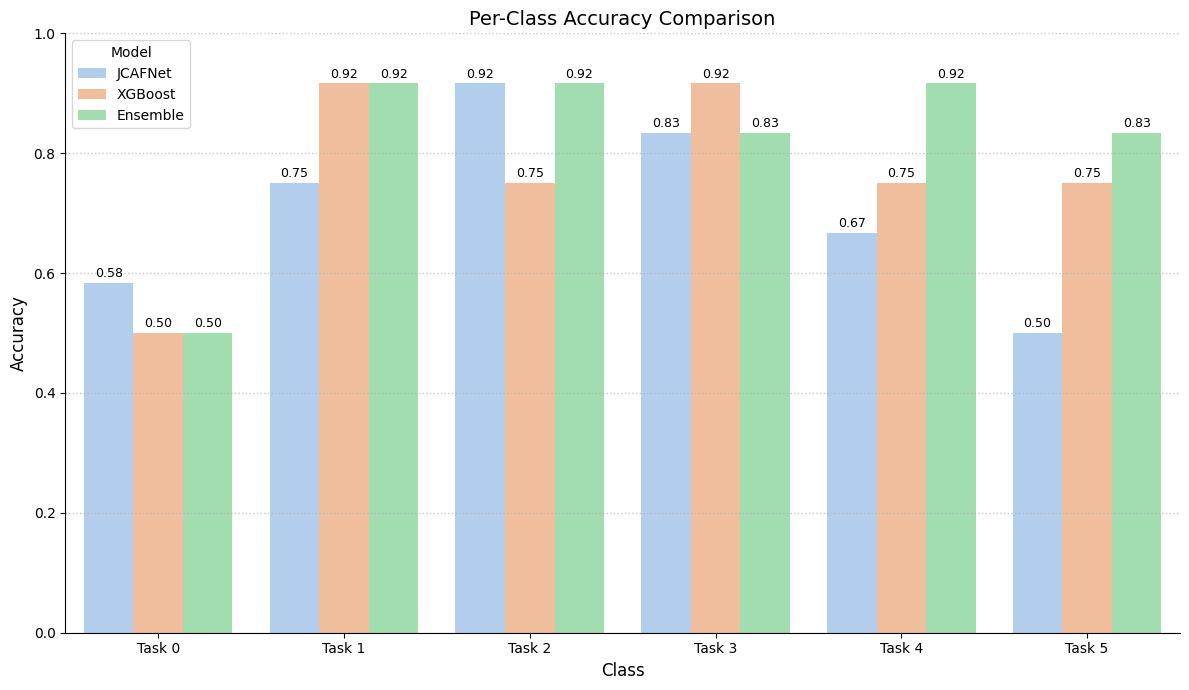

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def compare_per_class_accuracy(jcafnet_df, xgboost_df, ensemble_df, class_labels=None):
    def compute_per_class_acc(df):
        return df.groupby("true_label").apply(lambda g: (g["true_label"] == g["pred_label"]).mean())

    # Compute per-class accuracies
    jcafnet_acc = compute_per_class_acc(jcafnet_df)
    xgboost_acc = compute_per_class_acc(xgboost_df)
    ensemble_acc = compute_per_class_acc(ensemble_df)

    # Prepare dataframe for plotting
    acc_df = pd.DataFrame({
        "JCAFNet": jcafnet_acc,
        "XGBoost": xgboost_acc,
        "Ensemble": ensemble_acc
    }).reset_index().melt(id_vars="true_label", var_name="Model", value_name="Accuracy")

    # Optional: map class labels
    if class_labels:
        acc_df["Class"] = acc_df["true_label"].map(class_labels)
    else:
        acc_df["Class"] = acc_df["true_label"].astype(str)

    # Plot
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(
        data=acc_df, 
        x="Class", y="Accuracy", hue="Model", 
        palette="pastel", alpha=0.9
    )

    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9, padding=2)

    # Aesthetics
    ax.set_ylim(0, 1.0)
    ax.set_title("Per-Class Accuracy Comparison", fontsize=14)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.set_xlabel("Class", fontsize=12)
    ax.grid(True, axis="y", linestyle=":", linewidth=1, alpha=0.7)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()
    
class_labels = {
0: "Task 0",
1: "Task 1",
2: "Task 2",
3: "Task 3",
4: "Task 4",
5: "Task 5"
}

compare_per_class_accuracy(preds_jcafnet, preds_xgboost, ensemble_df, class_labels)

## Confidence distribution histograms

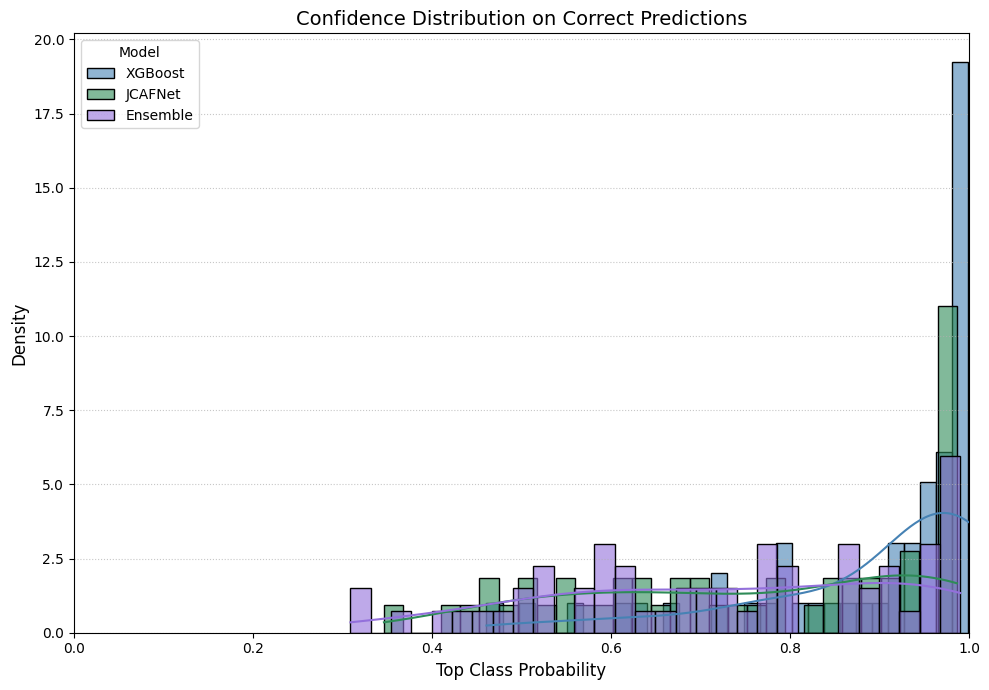

In [ ]:
def extract_top_confidences(df):
    probs = df[[f"class_{i}_prob" for i in range(6)]].values
    pred_label = df["pred_label"].values
    top_probs = probs[np.arange(len(probs)), pred_label]
    correct_flags = (df["true_label"] == df["pred_label"]).values
    return top_probs, correct_flags

# Extract top prediction confidences for correct predictions
probs_xgb, correct_flags_xgb = extract_top_confidences(preds_xgboost)
probs_jcafnet, correct_flags_jcafnet = extract_top_confidences(preds_jcafnet)
probs_ensemble, correct_flags_ensemble = extract_top_confidences(ensemble_df)

# Plot
plt.figure(figsize=(10, 7))
sns.histplot(
    x=probs_xgb[correct_flags_xgb], label="XGBoost", color="steelblue",
    kde=True, stat="density", alpha=0.6, bins=30
)
sns.histplot(
    x=probs_jcafnet[correct_flags_jcafnet], label="JCAFNet", color="seagreen",
    kde=True, stat="density", alpha=0.6, bins=30
)
sns.histplot(
    x=probs_ensemble[correct_flags_ensemble], label="Ensemble", color="mediumpurple",
    kde=True, stat="density", alpha=0.6, bins=30
)

# Formatting
plt.title("Confidence Distribution on Correct Predictions", fontsize=14)
plt.xlabel("Top Class Probability", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(True, axis='y', linestyle=':', alpha=0.7)
plt.legend(title="Model")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


## Venn Diagram 
(compare agreement between models using sets of correctly predicted samples)

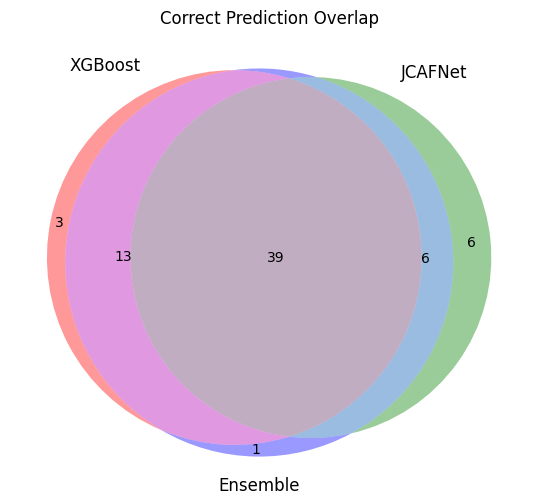

In [20]:
from matplotlib_venn import venn3
# For Venn diagram, we need sets of correct prediction indices
xgb_correct_set = set(np.where(correct_flags_xgb)[0])
jcafnet_correct_set = set(np.where(correct_flags_jcafnet)[0])
ensemble_correct_set = set(np.where(correct_flags_ensemble)[0])

plt.figure(figsize=(8, 6))
venn3([xgb_correct_set, jcafnet_correct_set, ensemble_correct_set], 
      set_labels=("XGBoost", "JCAFNet", "Ensemble"))
plt.title("Correct Prediction Overlap")
plt.show()

## Improvement heatmap

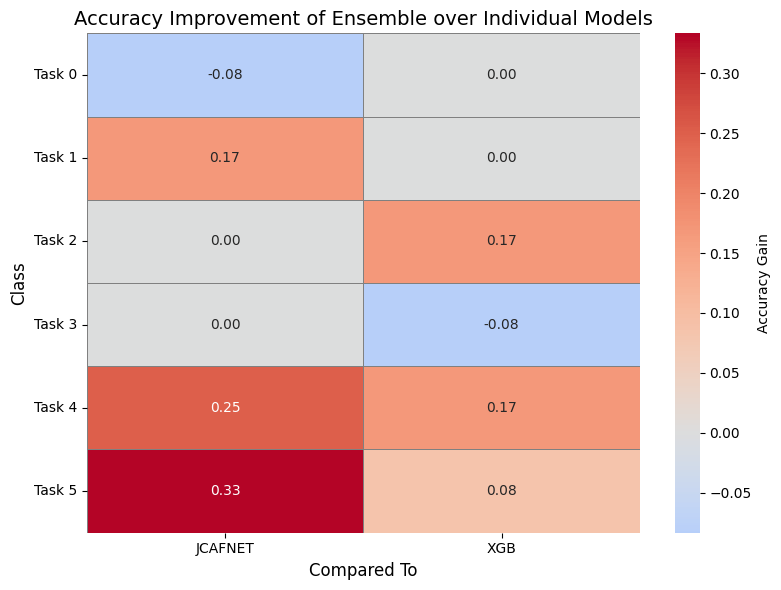

In [18]:
class_labels = {
    0: "Task 0",
    1: "Task 1",
    2: "Task 2",
    3: "Task 3",
    4: "Task 4",
    5: "Task 5"
}

# Build the DataFrame
data = {
    "true_label": ensemble_df["true_label"].to_list(),
    "xgb_correct": correct_flags_xgb,
    "jcafnet_correct": correct_flags_jcafnet,
    "ensemble_correct": correct_flags_ensemble,
}
df = pd.DataFrame(data)

# Compute per-class accuracy
acc_table = df.groupby("true_label")[["xgb_correct", "jcafnet_correct", "ensemble_correct"]].mean().reset_index()

# Compute improvement over individual models
acc_table["improvement_vs_xgb"] = acc_table["ensemble_correct"] - acc_table["xgb_correct"]
acc_table["improvement_vs_jcafnet"] = acc_table["ensemble_correct"] - acc_table["jcafnet_correct"]

# Melt for heatmap layout
heatmap_data = acc_table.melt(
    id_vars="true_label", 
    value_vars=["improvement_vs_xgb", "improvement_vs_jcafnet"],
    var_name="Compared To", value_name="Accuracy Gain"
)

# Format labels
heatmap_data["Compared To"] = heatmap_data["Compared To"].str.replace("improvement_vs_", "").str.upper()
heatmap_data["Class"] = heatmap_data["true_label"].map(class_labels) if class_labels else heatmap_data["true_label"].astype(str)

# Pivot for heatmap
heatmap_matrix = heatmap_data.pivot(index="Class", columns="Compared To", values="Accuracy Gain")

# Plot
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    heatmap_matrix, annot=True, fmt=".2f", cmap="coolwarm",
    center=0, linewidths=0.5, linecolor='gray', cbar_kws={"label": "Accuracy Gain"}
)

# Titles and labels
plt.title("Accuracy Improvement of Ensemble over Individual Models", fontsize=14)
plt.xlabel("Compared To", fontsize=12)
plt.ylabel("Class", fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
